In [34]:
using DataFrames
using DataFramesMeta
import DataFramesMeta.combine
using CSV
using MixedModels
using Statistics
using Distributions
using HypothesisTests
using GLM
using CairoMakie
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)
using MultipleTesting

# using StatsPlots

In [5]:
fc_day1 = DataFrame(CSV.File("tbl_loc_postc_mtl_sfc_rois.csv", missingstring="NA"))[:,2:end]
fc_day1

fc_day1.subject = "GLS" .* lpad.(string.(fc_day1.sub), 3, "0")
select!(fc_day1, Not(:sub))
sort!(fc_day1, [:subject, :condition, :run])

fc_learning = fc_day1[fc_day1.condition .== "Task",:]
fc_rest = fc_day1[fc_day1.condition .== "Rest",:]
fc_rest[fc_rest.run .<= 2, :condition] .= "Rest_1"
fc_rest[fc_rest.run .> 2, :condition] .= "Rest_2"
fc_rest_pre = fc_rest[fc_rest.run .<= 2,:]
fc_rest_post = fc_rest[fc_rest.run .> 2,:]

fc_recall_1 = DataFrame(CSV.File("tbl_loc_postc_mtl_sfc_rois_recall_Ses1.csv"))[:,2:end]
fc_recall_1.subject = "GLS" .* lpad.(string.(fc_recall_1.sub), 3, "0")
select!(fc_recall_1, Not(:sub))
fc_recall_1.condition .= "Recall_1"
sort!(fc_recall_1, [:subject, :condition, :run])

fc_recall_2 = DataFrame(CSV.File("tbl_loc_postc_mtl_sfc_rois_recall_Ses2.csv"))[:,2:end]
fc_recall_2.subject = "GLS" .* lpad.(string.(fc_recall_2.sub), 3, "0")
select!(fc_recall_2, Not(:sub))
fc_recall_2.condition .= "Recall_2"
sort!(fc_recall_2, [:subject, :condition, :run])

fc_all = vcat(fc_learning, fc_rest, fc_recall_1, fc_recall_2)
# ;

Row,graph,condition,run,rt,accuracy,avg_sfc,sfc_LOCqL_POSTCqL,sfc_LOCqL_POSTCqR,sfc_LOCqL_MTLqL,sfc_LOCqL_MTLqR,sfc_LOCqR_POSTCqL,sfc_LOCqR_POSTCqR,sfc_LOCqR_MTLqL,sfc_LOCqR_MTLqR,sfc_POSTCqL_MTLqL,sfc_POSTCqL_MTLqR,sfc_POSTCqR_MTLqL,sfc_POSTCqR_MTLqR,subject
,String7,String,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String
1,Modular,Task,1,1.29622,0.88,0.106133,0.0,0.00137588,0.0,0.0,0.0,0.0750702,0.0,0.0,0.329779,0.353612,0.260484,0.253269,GLS003
2,Modular,Task,2,1.17567,0.836667,0.122009,0.114301,0.152985,0.0,0.00227326,0.17087,0.229268,0.0,0.0337363,0.20881,0.220663,0.171611,0.159592,GLS003
3,Modular,Task,3,1.17843,0.833333,0.0583563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161492,0.151424,0.197723,0.189636,GLS003
4,Modular,Task,4,1.17269,0.85,0.236082,0.369145,0.339199,0.0,0.00531314,0.322149,0.207905,0.0,0.0436755,0.469874,0.407442,0.395756,0.272531,GLS003
5,Modular,Task,5,1.23813,0.876667,0.127507,0.185101,0.0917132,0.0,0.0,0.294423,0.211158,0.0,0.0,0.203418,0.152281,0.222825,0.169165,GLS003
6,Modular,Task,1,1.16244,0.923333,0.341536,0.335211,0.33041,0.290285,0.236765,0.453205,0.552229,0.307402,0.35881,0.169427,0.259298,0.383064,0.422329,GLS004
7,Modular,Task,2,1.07917,0.903333,0.301502,0.372428,0.469389,0.206197,0.0349057,0.462553,0.505395,0.259717,0.151549,0.257174,0.229225,0.334569,0.334917,GLS004
8,Modular,Task,3,1.05486,0.93,0.202154,0.462093,0.441796,0.166929,0.0983331,0.397497,0.401819,0.0894443,0.0580644,0.129438,0.0719166,0.0281517,0.0803615,GLS004
9,Modular,Task,4,1.07475,0.91,0.382186,0.196844,0.343973,0.40984,0.46034,0.254254,0.419545,0.367306,0.348406,0.46206,0.329288,0.489352,0.505026,GLS004


In [6]:
function zscore(x)
    return (x .- mean(x)) ./ std(x)
end

fc_learning.z_avg_sfc .= zscore(fc_learning.avg_sfc)
fc_learning.z_sfc_LOCqL_MTLqL .= zscore(fc_learning.sfc_LOCqL_MTLqL)
fc_learning.z_sfc_LOCqL_POSTCqL .= zscore(fc_learning.sfc_LOCqL_POSTCqL)
fc_learning.z_sfc_POSTCqL_MTLqL .= zscore(fc_learning.sfc_POSTCqL_MTLqL)
fc_learning.z_sfc_LOCqR_MTLqR .= zscore(fc_learning.sfc_LOCqR_MTLqR)
fc_learning.z_sfc_LOCqR_POSTCqR .= zscore(fc_learning.sfc_LOCqR_POSTCqR)
fc_learning.z_sfc_POSTCqR_MTLqR .= zscore(fc_learning.sfc_POSTCqR_MTLqR)
fc_learning.z_run = (fc_learning.run .- 3) ./ 2
fc_learning.log_rt = log.(fc_learning.rt)

fc_recall_1.z_avg_sfc .= zscore(fc_recall_1.avg_sfc)
fc_recall_1.z_sfc_LOCqL_MTLqL .= zscore(fc_recall_1.sfc_LOCqL_MTLqL)
fc_recall_1.z_sfc_LOCqL_POSTCqL .= zscore(fc_recall_1.sfc_LOCqL_POSTCqL)
fc_recall_1.z_sfc_POSTCqL_MTLqL .= zscore(fc_recall_1.sfc_POSTCqL_MTLqL)
fc_recall_1.z_sfc_LOCqR_MTLqR .= zscore(fc_recall_1.sfc_LOCqR_MTLqR)
fc_recall_1.z_sfc_LOCqR_POSTCqR .= zscore(fc_recall_1.sfc_LOCqR_POSTCqR)
fc_recall_1.z_sfc_POSTCqR_MTLqR .= zscore(fc_recall_1.sfc_POSTCqR_MTLqR)
fc_recall_1.z_run = (fc_recall_1.run .- 3) ./ 2
fc_recall_1.log_rt = log.(fc_recall_1.rt)

fc_recall_2.z_avg_sfc .= zscore(fc_recall_2.avg_sfc)
fc_recall_2.z_sfc_LOCqL_MTLqL .= zscore(fc_recall_2.sfc_LOCqL_MTLqL)
fc_recall_2.z_sfc_LOCqL_POSTCqL .= zscore(fc_recall_2.sfc_LOCqL_POSTCqL)
fc_recall_2.z_sfc_POSTCqL_MTLqL .= zscore(fc_recall_2.sfc_POSTCqL_MTLqL)
fc_recall_2.z_sfc_LOCqR_MTLqR .= zscore(fc_recall_2.sfc_LOCqR_MTLqR)
fc_recall_2.z_sfc_LOCqR_POSTCqR .= zscore(fc_recall_2.sfc_LOCqR_POSTCqR)
fc_recall_2.z_sfc_POSTCqR_MTLqR .= zscore(fc_recall_2.sfc_POSTCqR_MTLqR)
fc_recall_2.z_run = (fc_recall_2.run .- 4.5) ./ 3.5
fc_recall_2.log_rt = log.(fc_recall_2.rt)

fc_rest_pre.z_avg_sfc .= zscore(fc_rest_pre.avg_sfc)
fc_rest_pre.z_sfc_LOCqL_MTLqL .= zscore(fc_rest_pre.sfc_LOCqL_MTLqL)
fc_rest_pre.z_sfc_LOCqL_POSTCqL .= zscore(fc_rest_pre.sfc_LOCqL_POSTCqL)
fc_rest_pre.z_sfc_POSTCqL_MTLqL .= zscore(fc_rest_pre.sfc_POSTCqL_MTLqL)
fc_rest_pre.z_sfc_LOCqR_MTLqR .= zscore(fc_rest_pre.sfc_LOCqR_MTLqR)
fc_rest_pre.z_sfc_LOCqR_POSTCqR .= zscore(fc_rest_pre.sfc_LOCqR_POSTCqR)
fc_rest_pre.z_sfc_POSTCqR_MTLqR .= zscore(fc_rest_pre.sfc_POSTCqR_MTLqR)
fc_rest_pre.z_run = (fc_rest_pre.run .- 1.5)
fc_rest_pre.log_rt = log.(fc_rest_pre.rt)

fc_rest_post.z_avg_sfc .= zscore(fc_rest_post.avg_sfc)
fc_rest_post.z_sfc_LOCqL_MTLqL .= zscore(fc_rest_post.sfc_LOCqL_MTLqL)
fc_rest_post.z_sfc_LOCqL_POSTCqL .= zscore(fc_rest_post.sfc_LOCqL_POSTCqL)
fc_rest_post.z_sfc_POSTCqL_MTLqL .= zscore(fc_rest_post.sfc_POSTCqL_MTLqL)
fc_rest_post.z_sfc_LOCqR_MTLqR .= zscore(fc_rest_post.sfc_LOCqR_MTLqR)
fc_rest_post.z_sfc_LOCqR_POSTCqR .= zscore(fc_rest_post.sfc_LOCqR_POSTCqR)
fc_rest_post.z_sfc_POSTCqR_MTLqR .= zscore(fc_rest_post.sfc_POSTCqR_MTLqR)
fc_rest_post.z_run = (fc_rest_post.run .- 3.5)
fc_rest_post.log_rt = log.(fc_rest_post.rt)
;

# Classification Results

In [7]:
subjects = unique(fc_all.subject);
subjects_modular = unique(fc_all[fc_all.graph .== "Modular", :subject]);
subjects_lattice = unique(fc_all[fc_all.graph .== "Lattice", :subject]);
rois = (
    "postcentral-lh",
    "postcentral-rh",
    "postcentral-both",
    "precentral-lh",
    "precentral-rh",
    "precentral-both",
    "loc-localized",
    "loc-localized-lh",
    "loc-localized-rh",
    "hippocampus-lh",
    "hippocampus-rh",
    "hippocampus-both",
    "entorhinal-lh",
    "entorhinal-rh",
    "entorhinal-both",
)

("postcentral-lh", "postcentral-rh", "postcentral-both", "precentral-lh", "precentral-rh", "precentral-both", "loc-localized", "loc-localized-lh", "loc-localized-rh", "hippocampus-lh", "hippocampus-rh", "hippocampus-both", "entorhinal-lh", "entorhinal-rh", "entorhinal-both")

In [8]:
mvpa_results = DataFrame()
# let 
for subject in subjects
    for roi in rois
        project_dir = expanduser("~/GraphLearn")
        data_dir = "$(project_dir)/data"
        mvpa_dir = "mvpa_classifier"
        subtract_mean = "True"
        rescale = "True"
        classifier = "node"
        df = DataFrame(CSV.File("$(project_dir)/derived/$(mvpa_dir)/sub-$(subject)/sub-$(subject)_rescale-$(rescale)_subtract-mean-$(subtract_mean)_zstats_$(roi)_predictions-$(classifier).csv.gz"))
        df[:, :classifier] .= classifier
        df[:, :roi] .= roi
        if !hasproperty(df, :voxels)
            df[:, :voxels] .= 0
        end
        select!(df, Not(:Column1))
        # df[:, :subtract_mean] .= subtract_mean
        # df[:, :rescale] .= rescale
        mvpa_results = vcat(mvpa_results, df)
    end
end

In [9]:
mvpa_results.run .= mvpa_results.block .+ 1
mvpa_results[1:5, :]


Row,onset,duration,response_time,node,shape,variation,correct,is_hamiltonian,movement,movement_correct,graph,steadystate,block,subject,node_prev,block_prev,node_next,block_next,ind,pe_ind,cluster,cluster_prev,cluster_shifted_0,cluster_shifted_1,cluster_shifted_2,cluster_shifted_3,cluster_shifted_4,cross_cluster,node_group,prediction,correct_prediction,roi,classifier,subtract_mean,rescale,voxels,run
,Float64,Float64,Float64?,Int64,Int64,Int64,Bool,Bool,String7,String7,String7,Bool,Int64,String7,Int64,Int64,Int64?,Int64?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Bool,Int64,Int64,Bool,String31,String7,Bool,Bool,Int64,Int64
1,12.0,2.0,1.204,13,10,2,true,false,[00001],[00001],Modular,true,0,GLS003,11,0,12,0,1,0,3,3,3,3,1,1,1,false,3,5,false,postcentral-lh,node,true,true,0,1
2,18.0,2.0,1.23,12,12,3,false,false,[00011],[01001],Modular,true,0,GLS003,13,0,10,0,2,1,3,3,3,3,3,1,1,false,2,13,false,postcentral-lh,node,true,true,0,1
3,22.0,2.0,1.432,10,6,4,false,false,[10010],[00110],Modular,true,0,GLS003,12,0,9,0,3,2,3,3,3,3,3,3,3,false,0,10,true,postcentral-lh,node,true,true,0,1
4,26.0,2.0,1.718,9,9,0,false,false,[00110],[10010],Modular,true,0,GLS003,10,0,10,0,4,3,2,3,2,3,3,3,3,true,4,14,false,postcentral-lh,node,true,true,0,1
5,31.0,2.0,1.179,10,6,2,true,false,[00110],[00110],Modular,true,0,GLS003,9,0,12,0,5,4,3,2,3,3,3,3,3,true,0,6,false,postcentral-lh,node,true,true,0,1


In [10]:
acc_df = @chain mvpa_results begin
    @subset((:voxels .== 0) .| ((:voxels .== 200) .& (:roi .!= "loc-localized")) .| ((:voxels .== 400) .& (:roi .== "loc-localized")))
    @subset(:correct)
    @subset(:classifier .== "node")
    groupby([:subject, :roi, :graph])
    @combine(:mvpa_acc = mean(:correct_prediction))
end
acc_df[1:5, :]

Row,subject,roi,graph,mvpa_acc
,String7,String31,String7,Float64
1,GLS003,postcentral-lh,Modular,0.136111
2,GLS003,postcentral-rh,Modular,0.0944444
3,GLS003,postcentral-both,Modular,0.125
4,GLS003,precentral-lh,Modular,0.0888889
5,GLS003,precentral-rh,Modular,0.0944444


In [11]:
acc_df_run = @chain mvpa_results begin
    @subset((:voxels .== 0) .| ((:voxels .== 200) .& (:roi .!= "loc-localized")) .| ((:voxels .== 400) .& (:roi .== "loc-localized")))
    @subset(:correct)
    @subset(:classifier .== "node")
    groupby([:subject, :roi, :graph, :run])
    @combine(:mvpa_run_acc = mean(:correct_prediction))
end
acc_df_run[1:5, :]

Row,subject,roi,graph,run,mvpa_run_acc
,String7,String31,String7,Int64,Float64
1,GLS003,postcentral-lh,Modular,1,0.16129
2,GLS003,postcentral-lh,Modular,2,0.1
3,GLS003,postcentral-lh,Modular,3,0.111111
4,GLS003,postcentral-lh,Modular,4,0.0888889
5,GLS003,postcentral-lh,Modular,5,0.16


# General FC Trends

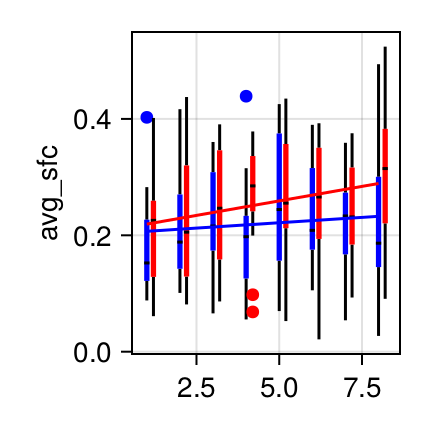

In [408]:
# avg sfc
val = :avg_sfc
df = fc_recall_2
nruns = 8
results = fit(MixedModel, @formula(avg_sfc ~ 1 + run * graph + (1 + run * graph | subject)), df, progress=false)

f = Figure(size=72 .* (3.0, 3.0))
ax = Axis(f[1,1], 
    ylabel=string(val),
    # palette = (; patchcolor = colors),
    # title = "6.2 LRL Blockwise λs (Baseline)",
)
for run in 1:nruns
    boxplot!(zeros(16) .+ run, df[(df.graph .== "Modular") .& (df.run .== run), val], width=0.2, color=:blue)
    boxplot!(zeros(15) .+ run .+ 0.2, df[(df.graph .== "Lattice") .& (df.run .== run), val], width=0.2, color=:red)
end
lines!(1:nruns, fixef(results)[1] .+ fixef(results)[2] .* (1:nruns), color=:red)
lines!(1:nruns, fixef(results)[1] + fixef(results)[3] .+ (fixef(results)[2] + fixef(results)[4]) .* (1:nruns), color=:blue)
f

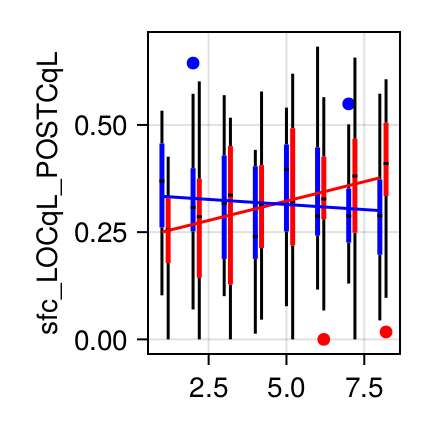

In [409]:
# avg sfc
val = :sfc_LOCqL_POSTCqL
df = fc_recall_2
nruns = 8
results = fit(MixedModel, @formula(sfc_LOCqL_POSTCqL ~ 1 + run * graph + (1 + run * graph | subject)), df, progress=false)

f = Figure(size=72 .* (3.0, 3.0))
ax = Axis(f[1,1], 
    ylabel=string(val),
    # palette = (; patchcolor = colors),
    # title = "6.2 LRL Blockwise λs (Baseline)",
)
for run in 1:nruns
    boxplot!(zeros(16) .+ run, df[(df.graph .== "Modular") .& (df.run .== run), val], width=0.2, color=:blue)
    boxplot!(zeros(15) .+ run .+ 0.2, df[(df.graph .== "Lattice") .& (df.run .== run), val], width=0.2, color=:red)
end
lines!(1:nruns, fixef(results)[1] .+ fixef(results)[2] .* (1:nruns), color=:red)
lines!(1:nruns, fixef(results)[1] + fixef(results)[3] .+ (fixef(results)[2] + fixef(results)[4]) .* (1:nruns), color=:blue)
f

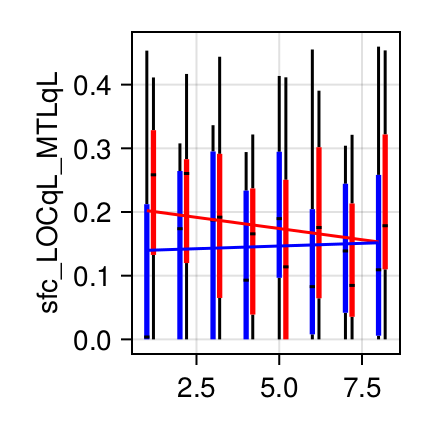

In [410]:
# avg sfc
val = :sfc_LOCqL_MTLqL
df = fc_recall_2
nruns = 8
results = fit(MixedModel, @formula(sfc_LOCqL_MTLqL ~ 1 + run * graph + (1 + run * graph | subject)), df, progress=false)

f = Figure(size=72 .* (3.0, 3.0))
ax = Axis(f[1,1], 
    ylabel=string(val),
    # palette = (; patchcolor = colors),
    # title = "6.2 LRL Blockwise λs (Baseline)",
)
for run in 1:nruns
    boxplot!(zeros(16) .+ run, df[(df.graph .== "Modular") .& (df.run .== run), val], width=0.2, color=:blue)
    boxplot!(zeros(15) .+ run .+ 0.2, df[(df.graph .== "Lattice") .& (df.run .== run), val], width=0.2, color=:red)
end
lines!(1:nruns, fixef(results)[1] .+ fixef(results)[2] .* (1:nruns), color=:red)
lines!(1:nruns, fixef(results)[1] + fixef(results)[3] .+ (fixef(results)[2] + fixef(results)[4]) .* (1:nruns), color=:blue)
f

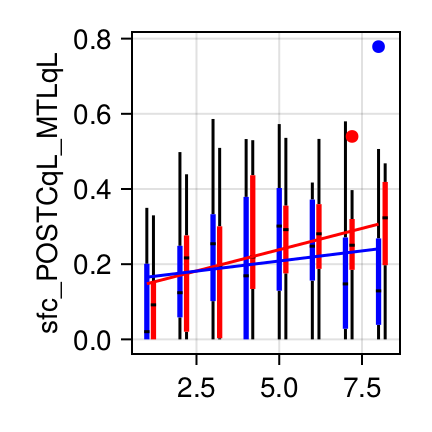

In [411]:
# avg sfc
val = :sfc_POSTCqL_MTLqL
df = fc_recall_2
nruns = 8
results = fit(MixedModel, @formula(sfc_POSTCqL_MTLqL ~ 1 + run * graph + (1 + run * graph | subject)), df, progress=false)

f = Figure(size=72 .* (3.0, 3.0))
ax = Axis(f[1,1], 
    ylabel=string(val),
    # palette = (; patchcolor = colors),
    # title = "6.2 LRL Blockwise λs (Baseline)",
)
for run in 1:nruns
    boxplot!(zeros(16) .+ run, df[(df.graph .== "Modular") .& (df.run .== run), val], width=0.2, color=:blue)
    boxplot!(zeros(15) .+ run .+ 0.2, df[(df.graph .== "Lattice") .& (df.run .== run), val], width=0.2, color=:red)
end
lines!(1:nruns, fixef(results)[1] .+ fixef(results)[2] .* (1:nruns), color=:red)
lines!(1:nruns, fixef(results)[1] + fixef(results)[3] .+ (fixef(results)[2] + fixef(results)[4]) .* (1:nruns), color=:blue)
f

# Learning FC vs. Recall MVPA

In [38]:
x1 = combine(groupby(fc_learning, :subject), :sfc_POSTCqL_MTLqL => mean, :sfc_LOCqL_MTLqL => mean, :sfc_LOCqL_POSTCqL => mean)
x2 = acc_df[acc_df.roi .== "postcentral-lh", :]
df = innerjoin(x1, x2, on=:subject)
df.z_sfc_POSTCqL_MTLqL_mean = zscore(df.sfc_POSTCqL_MTLqL_mean)
df.z_sfc_LOCqL_MTLqL_mean = zscore(df.sfc_LOCqL_MTLqL_mean)
df.z_sfc_LOCqL_POSTCqL_mean = zscore(df.sfc_LOCqL_POSTCqL_mean)
results = fit(MixedModel, @formula(mvpa_acc ~ 1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) + (1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) | subject)), df, progress=false)
results_postcentral = results
show(MIME("text/latex"), results)

\begin{tabular}
{l | r | r | r | r | r}
 & Est. & SE & z & p & $\sigma_\text{subject}$ \\
\hline
(Intercept) & 0.1245 & 0.0035 & 35.90 & <1e-99 & 0.0180 \\
z\_sfc\_LOCqL\_MTLqL\_mean & -0.0135 & 0.0051 & -2.65 & 0.0082 & 0.0146 \\
z\_sfc\_POSTCqL\_MTLqL\_mean & 0.0058 & 0.0040 & 1.44 & 0.1508 & 0.0043 \\
z\_sfc\_LOCqL\_POSTCqL\_mean & 0.0110 & 0.0039 & 2.86 & 0.0043 & 0.0117 \\
Residual & 0.0000 &  &  &  &  \\
\end{tabular}


In [39]:
x1 = combine(groupby(fc_learning, :subject), :sfc_POSTCqL_MTLqL => mean, :sfc_LOCqL_MTLqL => mean, :sfc_LOCqL_POSTCqL => mean)
x2 = acc_df[acc_df.roi .== "loc-localized-lh", :]
df = innerjoin(x1, x2, on=:subject)
df.z_sfc_POSTCqL_MTLqL_mean = zscore(df.sfc_POSTCqL_MTLqL_mean)
df.z_sfc_LOCqL_MTLqL_mean = zscore(df.sfc_LOCqL_MTLqL_mean)
df.z_sfc_LOCqL_POSTCqL_mean = zscore(df.sfc_LOCqL_POSTCqL_mean)
results = fit(MixedModel, @formula(mvpa_acc ~ 1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) + (1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) | subject)), df, progress=false)
results_loc = results
show(MIME("text/latex"), results)

\begin{tabular}
{l | r | r | r | r | r}
 & Est. & SE & z & p & $\sigma_\text{subject}$ \\
\hline
(Intercept) & 0.2030 & 0.0085 & 24.01 & <1e-99 & 0.0412 \\
z\_sfc\_LOCqL\_MTLqL\_mean & -0.0029 & 0.0105 & -0.28 & 0.7788 & 0.0377 \\
z\_sfc\_POSTCqL\_MTLqL\_mean & 0.0148 & 0.0067 & 2.20 & 0.0280 & 0.0262 \\
z\_sfc\_LOCqL\_POSTCqL\_mean & -0.0031 & 0.0055 & -0.57 & 0.5677 & 0.0189 \\
Residual & 0.0000 &  &  &  &  \\
\end{tabular}


In [40]:
x1 = combine(groupby(fc_learning, :subject), :sfc_POSTCqL_MTLqL => mean, :sfc_LOCqL_MTLqL => mean, :sfc_LOCqL_POSTCqL => mean)
x2 = acc_df[acc_df.roi .== "hippocampus-lh", :]
df = innerjoin(x1, x2, on=:subject)
df.z_sfc_POSTCqL_MTLqL_mean = zscore(df.sfc_POSTCqL_MTLqL_mean)
df.z_sfc_LOCqL_MTLqL_mean = zscore(df.sfc_LOCqL_MTLqL_mean)
df.z_sfc_LOCqL_POSTCqL_mean = zscore(df.sfc_LOCqL_POSTCqL_mean)
results = fit(MixedModel, @formula(mvpa_acc ~ 1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) + (1 + (z_sfc_LOCqL_MTLqL_mean + z_sfc_POSTCqL_MTLqL_mean + z_sfc_LOCqL_POSTCqL_mean) | subject)), df, progress=false)
results_hippocampus = results
show(MIME("text/latex"), results)

\begin{tabular}
{l | r | r | r | r | r}
 & Est. & SE & z & p & $\sigma_\text{subject}$ \\
\hline
(Intercept) & 0.0668 & 0.0025 & 26.49 & <1e-99 & 0.0133 \\
z\_sfc\_LOCqL\_MTLqL\_mean & 0.0156 & 0.0036 & 4.32 & <1e-04 & 0.0194 \\
z\_sfc\_POSTCqL\_MTLqL\_mean & -0.0037 & 0.0004 & -8.26 & <1e-15 & 0.0021 \\
z\_sfc\_LOCqL\_POSTCqL\_mean & -0.0144 & 0.0029 & -4.93 & <1e-06 & 0.0158 \\
Residual & 0.0000 &  &  &  &  \\
\end{tabular}
